In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('birds-250')
jovian.set_colab_id('14WGI4RtgfG4UfQaJg4yPTvt71dEGbuZs')

In [ ]:
!pip install jovian --upgrade --quiet

# Image Classification on 250 Bird Species
An insight to the **ResNet** model that train a dataset to classify 250 different bird species according to their labels.


Dataset contains 250 bird species of which 35215 are **Training** images, 1250 are **Test** images and 1250 are **Validation** images. All images are 224 x 224 x 3 color images in jpg format.  Also includes a **consolidated** image set that combines the training, test and validation images into a single data set.

## Importing the Libraries:
Let’s start with importing the required modules & libraries.

In [ ]:
import os 
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
# Project Title
project_name = 'birds-250'

## Importing the Dataset from Kaggle

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import os
import shutil
import opendatasets as od

if os.path.exists('./100-bird-species'):
  shutil.rmtree('./100-bird-species')

In [ ]:
dataset_url = 'https://www.kaggle.com/gpiosenka/100-bird-species'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: venupodugu
Your Kaggle Key: ··········


  1%|          | 17.0M/1.54G [00:00<00:14, 110MB/s]

100%|██████████| 1.54G/1.54G [00:07<00:00, 215MB/s] 


## Exploring the Data

In [ ]:
data_dir = './100-bird-species'
print('Folders: ', os.listdir(data_dir))

Folders:  ['train', 'valid', 'consolidated', 'test']


In [ ]:
classes = os.listdir(data_dir + '/train')
print('Number of classes: ', len(classes))
print('First 20 classes names: ', classes[:20])

Number of classes:  250
First 20 classes names:  ['NORTHERN CARDINAL', 'ROSY FACED LOVEBIRD', 'BLACK VULTURE', 'BARRED PUFFBIRD', 'GLOSSY IBIS', 'GOLD WING WARBLER', 'FLAME TANAGER', 'BAY-BREASTED WARBLER', 'BLACK-THROATED SPARROW', 'OCELLATED TURKEY', 'PARUS MAJOR', 'COCKATOO', 'NORTHERN PARULA', 'SPOONBILL', 'AMERICAN AVOCET', 'INDIGO BUNTING', 'NORTHERN MOCKINGBIRD', 'CRESTED CARACARA', 'VARIED THRUSH', 'ANTBIRD']


## Transforming the data to Tensors
We can create **training**, **validation** and **test** datasets using the ImageFolder class from torchvision. In addition to the **ToTensor** transform, can also apply some other transforms to the images. There are a few important changes we'll make while creating PyTorch datasets for training and validation

### Channel-wise Data Normalization:
We will **normalize** the image tensors by subtracting the **mean** and dividing by the **standard deviation** across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

In [ ]:
stats = ((0.4699, 0.4684, 0.3957), (0.2379, 0.2319, 0.2542))

train_tfms = tt.Compose([tt.ToTensor(),
                         tt.Normalize(*stats, inplace=True)])

val_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

test_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])


# PyTorch datasets

### Why do we split the data into Training and Validation and Test datasets?

While building real world machine learning models, it is quite common to split the data set into 3 parts:

**1. Training set:** Used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.

**2. Validation set:** Used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.

**3. Test set:** Used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

In [ ]:
train_ds = ImageFolder(data_dir + '/train', train_tfms)
val_ds = ImageFolder(data_dir + '/valid', val_tfms)
test_ds = ImageFolder(data_dir + '/valid', test_tfms)

In [ ]:
print('Train_ds length: ', len(train_ds))
print('Val_ds length: ', len(val_ds))
print('Test_ds length: ', len(test_ds))


Train_ds length:  35215
Val_ds length:  1250
Test_ds length:  1250


# Batch size
The batch size is the number of samples (data points) that would be passed through the network at a time. The size of the batch can be between one and the number of samples in the training set. 

In [ ]:
batch_size = 64

# PyTorch DataLoaders
Next, we can create **data loaders** for retrieving images in batches. can use a relatively large batch size of 500 to utlize a larger portion of the GPU RAM. You can try reducing the batch size & restarting the kernel if you face an **out of memory** error.

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

## Visualizing Sample dataset

In [ ]:
def denormalize(images, means, stds):
  means = torch.tensor(means).reshape(1,3,1,1)
  stds = torch.tensor(stds).reshape(1,3,1,1)
  return images * stds + means

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([])
    ax.set_yticks([])
    denorm_images = denormalize(images, *stats)
    ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1,2,0).clamp(0,1))
    break

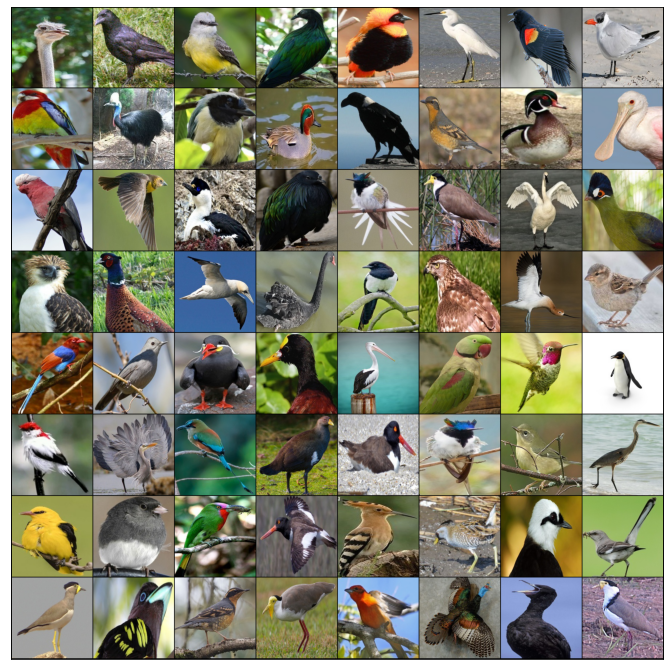

In [ ]:
show_batch(train_dl)

# Using a GPU
To seamlessly use a **GPU**, if one is available, we define a couple of helper functions (**get_default_device & to_device**) and a helper class **DeviceDataLoader** to move our model & data to the GPU as required.

In [ ]:
def get_default_device():
  """ Pick GPU if available, else CPU """
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
   """ Move tensor(s) to chosen device """
   if isinstance(data, (list, tuple)):
     return [to_device(x, device) for x in data]
   return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """ Wrap a dataloader to move data to a device """
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """ Yield a batch of data after moving it to device """
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """ Number of batches """
    return len(self.dl)

Based on where you're running this notebook, your default device could be a **CPU** (torch.device('cpu')) or a **GPU** (torch.device('cuda'))



In [ ]:
device = get_default_device()
device

device(type='cuda')

## DeviceDataLoader
We can now wrap our training and validation data loaders using **DeviceDataLoader** for automatically transferring batches of data to the GPU (if available).

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Epoch
An **epoch** is one single pass of all the input data through the network. An epoch is a term used in machine learning and indicates the number of passes of the entire training dataset the machine learning algorithm has completed. Datasets are usually grouped into batches (especially when the amount of data is very large). The number of epochs is the number of complete passes through the training dataset.

# Model with Residual Blocks and Batch Normalization
Here we are adding **Residual block** to the **CNN** model, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

Few small changes in the network produces a drastic improvement in the performance of the model. Also, after each convolutional layer, we'll add a batch normalization layer, which normalizes the outputs of the previous layer.

Go through the following blog posts to learn more:

* Why and how residual blocks work: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec
* Batch normalization and dropout explained: https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))

class ImageClassificationBase(nn.Module):

  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()      # Combine Losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()         # Combine Accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

  

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)]
  if pool: layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)


class ResNet9(ImageClassificationBase):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    self.conv1 = conv_block(in_channels, 64, pool=True)
    self.conv2 = conv_block(64, 128, pool=True)
    self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

    self.conv3 = conv_block(128, 256, pool=True)
    self.conv4 = conv_block(256, 512, pool=True)
    self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

    self.conv5 = conv_block(512, 1024, pool=True)
    self.res3 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))

    self.classifier = nn.Sequential(nn.MaxPool2d(7),
                                    nn.Flatten(),
                                    nn.Dropout(0.2),
                                    nn.Linear(1024, num_classes))
    
  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out

    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out

    out = self.conv5(out)
    out = self.res3(out) + out

    out = self.classifier(out)
    return out

In [ ]:
model = to_device(ResNet9(3,250), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e

## Training the Model
Before we train the model, we're going to make a bunch of small but important improvements to our fit function:

* **Learning rate scheduling:** Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the **One Cycle Learning Rate Policy**, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html

* **Weight decay:** We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

* **Gradient clipping:** Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48

Let's define a **fit_one_cycle** function to incorporate these changes. We'll also record the learning rate used for each batch.



In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  history = []

  # Setup custom optimizer with weight decay
  optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

  # Setup One_cycle learning rate scheduler
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, 
                                              epochs=epochs, 
                                              steps_per_epoch=len(train_loader))
  
  for epoch in range(epochs):
    # Training Phase
    model.train()
    train_losses = []
    lrs = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()

      # Gradient Clipping
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

      optimizer.step()
      optimizer.zero_grad()

      # Record & Update learning rate
      lrs.append(get_lr(optimizer))
      sched.step()

    # Validation phase
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['lrs'] = lrs
    model.epoch_end(epoch, result)
    history.append(result)
  return history

## Model Evaluation

In [ ]:
history = [evaluate(model, val_dl)]
history

[{'val_acc': 0.004687500186264515, 'val_loss': 5.521665573120117}]

We're now ready to train our model. Instead of **SGD** (stochastic gradient descent), we'll use the **Adam optimizer** which uses techniques like momentum and adaptive learning rates for faster training. You can learn more about optimizers here: https://ruder.io/optimizing-gradient-descent/index.html

In [ ]:
epochs = 12
max_lr = .01
grad_clip = .1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, 
                         val_dl, grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], last_lr: 0.00211, train_loss: 5.1453, val_loss: 4.7350, val_acc: 0.1369
Epoch [1], last_lr: 0.00603, train_loss: 3.5719, val_loss: 2.7900, val_acc: 0.3789
Epoch [2], last_lr: 0.00936, train_loss: 2.1094, val_loss: 1.6910, val_acc: 0.5598
Epoch [3], last_lr: 0.00994, train_loss: 1.6076, val_loss: 1.3799, val_acc: 0.6549
Epoch [4], last_lr: 0.00933, train_loss: 1.3308, val_loss: 1.0659, val_acc: 0.7255
Epoch [5], last_lr: 0.00812, train_loss: 1.1293, val_loss: 1.0483, val_acc: 0.7193
Epoch [6], last_lr: 0.00647, train_loss: 0.9287, val_loss: 0.8164, val_acc: 0.7898
Epoch [7], last_lr: 0.00463, train_loss: 0.7034, val_loss: 0.4307, val_acc: 0.8870
Epoch [8], last_lr: 0.00283, train_loss: 0.4786, val_loss: 0.3053, val_acc: 0.9223
Epoch [9], last_lr: 0.00133, train_loss: 0.2737, val_loss: 0.1921, val_acc: 0.9468
Epoch [10], last_lr: 0.00035, train_loss: 0.1211, val_loss: 0.1540, val_acc: 0.9615
Epoch [11], last_lr: 0.00000, train_loss: 0.0649, val_loss: 0.1537, val_acc: 0.9572
CP

In [ ]:
train_time = '55:13'

Let's plot the **valdation set accuracies** to study how the model improves over time.

In [ ]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-o')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Accuracy Vs No.of epochs')

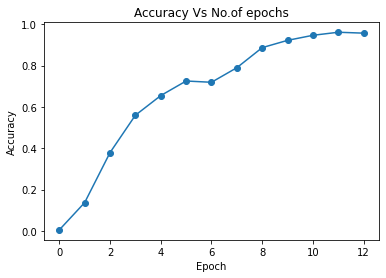

In [ ]:
plot_accuracies(history)

We can also plot the **training** and **validation losses** to study the trend.

In [ ]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bo')
  plt.plot(val_losses, '-ro')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss Vs No.of Epochs')
  plt.legend(['Training','Validation'])

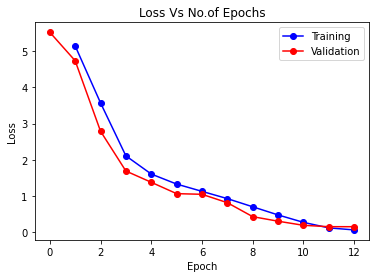

In [ ]:
plot_losses(history)

It's clear from the trend that our model isn't overfitting to the training data just yet. Try removing batch normalization, data augmentation and residual layers one by one to study their effect on overfitting.

Finally, let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

In [ ]:
def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs', []) for x in history])
  plt.plot(lrs)
  plt.xlabel('Batch No.')
  plt.ylabel('Learning rate')
  plt.title('Learning rate Vs Batch No.')

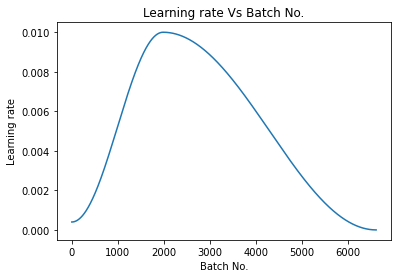

In [ ]:
plot_lrs(history)

As expected, the learning rate starts at a low value, and gradually increases for 30% of the iterations to a maximum value of 0.01, and then gradually decreases to a very small value.

## Testing with individual images

In [ ]:
len(test_ds)

1250

Testing with individual images
While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 1250 images.

In [ ]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
      images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', test_ds.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

In [ ]:
def predict_image(img, model):
  # Convert to a batch of 1
  xb = to_device(img.unsqueeze(0), device)
  # Get predictions from model
  yb = model(xb)
  # Pick index with highest probability
  _, preds = torch.max(yb, dim=1)
  # Retrieve the class label
  return test_ds.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: AMERICAN BITTERN (5)
Target: AMERICAN BITTERN
Prediction: AMERICAN BITTERN


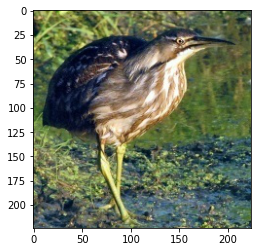

In [ ]:
img, label = test_ds[25]
show_image(img, label)
pred = predict_image(img, model, test_ds.classes)
print('Target:', test_ds.classes[label])
print('Prediction:', pred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: MYNA (150)
Target: MYNA
Prediction: MYNA


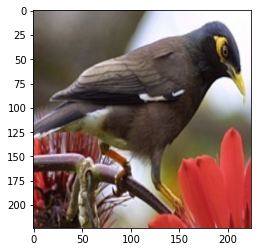

In [ ]:
img, label = test_ds[750]
show_image(img, label)
pred = predict_image(img, model, test_ds.classes)
print('Target:', test_ds.classes[label])
print('Prediction:', pred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: LEARS MACAW (137)
Target: LEARS MACAW
Prediction: LEARS MACAW


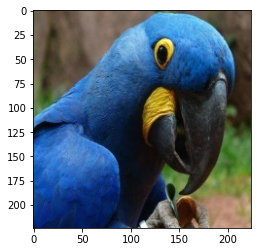

In [ ]:
img, label = test_ds[689]
show_image(img, label)
pred = predict_image(img, model, test_ds.classes)
print('Target:', test_ds.classes[label])
print('Prediction:', pred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: SNOWY OWL (209)
Target: SNOWY OWL
Prediction: SNOWY OWL


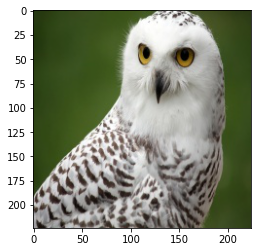

In [ ]:
img, label = test_ds[1046]
show_image(img, label)
pred = predict_image(img, model, test_ds.classes)
print('Target:', test_ds.classes[label])
print('Prediction:', pred)

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

## Save and Commit
Let's save the weights of the model, record the hyperparameters, and commit our experiment to Jovian. As you try different ideas, make sure to record every experiment so you can look back and analyze the results.

In [ ]:
torch.save(model.state_dict(), 'birds-250.pth')

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch = 'resnet9', epochs = epochs,
                       lr = max_lr, scheduler = 'one-cycle',
                       weight_decay = weight_decay,
                       grad_clip = grad_clip,
                       opt = opt_func.__name__)

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Hyperparams logged.


In [ ]:
jovian.log_metrics(val_loss = history[-1]['val_loss'],
                   val_acc = history[-1]['val_acc'],
                   train_loss = history[-1]['train_loss'],
                   time = train_time)

[jovian] Metrics logged.


In [ ]:
jovian.commit(project = project_name, environment = None, outputs =['birds-250.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...


[jovian] Error: ('Connection aborted.', BrokenPipeError(32, 'Broken pipe')) (birds-250.pth)


[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/poduguvenu/birds-250


'https://jovian.ai/poduguvenu/birds-250'

# Transfer Learning

In [ ]:
from torchvision import models

class ResNet34(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = to_device(ResNet34(len(train_ds.classes), pretrained=True), device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
history = [evaluate(model, val_dl)]
history

[{'val_acc': 0.0023437500931322575, 'val_loss': 5.769628524780273}]

In [ ]:
history += fit_one_cycle(10, 0.0005, model, train_dl, val_dl, weight_decay=0.01, grad_clip=0.1, opt_func=torch.optim.Adam)

Epoch [0], last_lr: 0.00014, train_loss: 3.0903, val_loss: 0.5892, val_acc: 0.9127
Epoch [1], last_lr: 0.00038, train_loss: 1.0397, val_loss: 1.8304, val_acc: 0.5631
Epoch [2], last_lr: 0.00050, train_loss: 1.3616, val_loss: 1.4982, val_acc: 0.6175
Epoch [3], last_lr: 0.00048, train_loss: 1.3110, val_loss: 1.3549, val_acc: 0.6696
Epoch [4], last_lr: 0.00041, train_loss: 1.2032, val_loss: 1.1430, val_acc: 0.7235
Epoch [5], last_lr: 0.00031, train_loss: 1.0478, val_loss: 1.0009, val_acc: 0.8052
Epoch [6], last_lr: 0.00019, train_loss: 0.8350, val_loss: 0.6376, val_acc: 0.8868
Epoch [7], last_lr: 0.00009, train_loss: 0.5757, val_loss: 0.3844, val_acc: 0.9469
Epoch [8], last_lr: 0.00002, train_loss: 0.3539, val_loss: 0.2635, val_acc: 0.9722
Epoch [9], last_lr: 0.00000, train_loss: 0.2487, val_loss: 0.2449, val_acc: 0.9691


Let's plot the **valdation set accuracies** to study how the model improves over time.

In [ ]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-o')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Accuracy Vs No.of epochs')

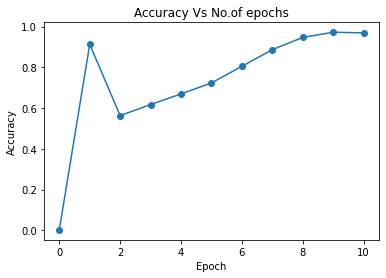

In [ ]:
plot_accuracies(history)

We can also plot the **training** and **validation losses** to study the trend.

In [ ]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bo')
  plt.plot(val_losses, '-ro')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss Vs No.of Epochs')
  plt.legend(['Training','Validation'])

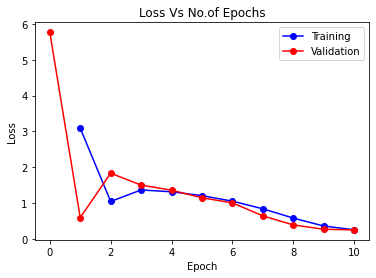

In [ ]:
plot_losses(history)

It's clear from the trend that our model isn't overfitting to the training data just yet. Try removing batch normalization, data augmentation and residual layers one by one to study their effect on overfitting.

Finally, let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

In [ ]:
def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs', []) for x in history])
  plt.plot(lrs)
  plt.xlabel('Batch No.')
  plt.ylabel('Learning rate')
  plt.title('Learning rate Vs Batch No.')

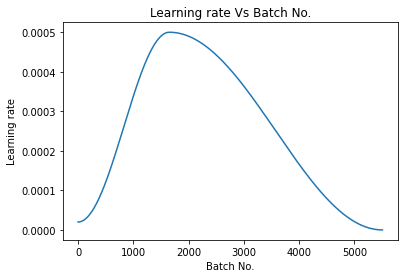

In [ ]:
plot_lrs(history)

As expected, the learning rate starts at a low value, and gradually increases for 30% of the iterations to a maximum value of 0.0005, and then gradually decreases to a very small value.

## Testing with individual images

In [ ]:
len(test_ds)

1250

Testing with individual images
While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 1250 images.

In [ ]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
      images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', test_ds.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

In [ ]:
def predict_image(img, model, classes):
  # Convert to a batch of 1
  xb = to_device(img.unsqueeze(0), device)
  # Get predictions from model
  yb = model(xb)
  # Pick index with highest probability
  _, preds = torch.max(yb, dim=1)
  # Retrieve the class label
  return test_ds.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: AFRICAN CROWNED CRANE (0)
Target: AFRICAN CROWNED CRANE
Prediction: AFRICAN CROWNED CRANE


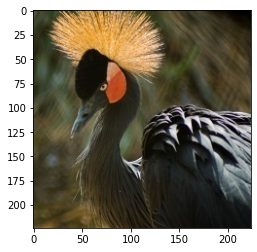

In [ ]:
img, label = test_ds[0]
show_image(img, label)
pred = predict_image(img, model, test_ds.classes)
print('Target:', test_ds.classes[label])
print('Prediction:', pred)

Label: CARMINE BEE-EATER (50)
Target: CARMINE BEE-EATER
Prediction: CARMINE BEE-EATER


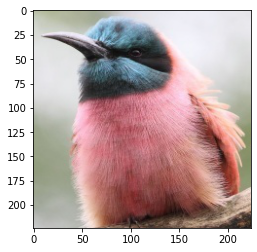

In [ ]:
img, label = test_ds[250]
show_image(img, label)
pred = predict_image(img, model, test_ds.classes)
print('Target:', test_ds.classes[label])
print('Prediction:', pred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: LARK BUNTING (136)
Target: LARK BUNTING
Prediction: LARK BUNTING


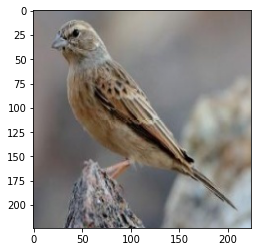

In [ ]:
img, label = test_ds[680]
show_image(img, label)
pred = predict_image(img, model, test_ds.classes)
print('Target:', test_ds.classes[label])
print('Prediction:', pred)

Label: SPANGLED COTINGA (211)
Target: SPANGLED COTINGA
Prediction: SPANGLED COTINGA


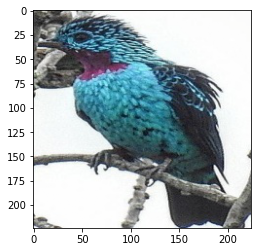

In [ ]:
img, label = test_ds[1056]
show_image(img, label)
pred = predict_image(img, model, test_ds.classes)
print('Target:', test_ds.classes[label])
print('Prediction:', pred)

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

## Save and Commit
Let's save the weights of the model, record the hyperparameters, and commit our experiment to Jovian. As you try different ideas, make sure to record every experiment so you can look back and analyze the results.

In [ ]:
torch.save(model.state_dict(), 'birds-250.pth')

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch = 'resnet34', epochs = epochs,
                       lr = max_lr, scheduler = 'one-cycle',
                       weight_decay = weight_decay,
                       grad_clip = grad_clip,
                       opt = opt_func.__name__)

[jovian] Hyperparams logged.


In [ ]:
jovian.log_metrics(val_loss = history[-1]['val_loss'],
                   val_acc = history[-1]['val_acc'],
                   train_loss = history[-1]['train_loss'],
                   time = train_time)

[jovian] Metrics logged.


In [ ]:
jovian.commit(project = project_name, environment = None, outputs =['birds-250.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/poduguvenu/birds-250


'https://jovian.ai/poduguvenu/birds-250'